## Imports & Pre-amble
---

In [1]:
# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Hugging Face Imports
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

# Sklearn Imports
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Mathematical Imports
import numpy as np
import random

# Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Removing deprecation warnings
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [3]:
# Setting random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 1 - Sentence Transformer
---
#### **Notes on Model Choice**
- Using BGE-M3 by Beijing Academy of Artificial Intelligence (BAAI) - https://huggingface.co/BAAI/bge-m3
- Selected because it is optimized for multi-task learning and has generalized embeddings.
- Model is pre-trained, efficient and reasonably lightweight for the tasks at hand while still having good accuracy.

In [4]:
sentences = [
    "The golden rays of the setting sun painted the sky in shades of orange and pink.",
    "A sudden downpour drenched the city streets, leaving behind the fresh scent of rain.",
    "She hesitated before stepping onto the stage, her heartbeat quickening with anticipation.",
    "The discovery of a hidden passage behind the old bookshelf changed everything.",
    "Despite years of effort, scientists have yet to fully understand the nature of dark matter.",
    "In the stillness of the forest, the only sound was the distant hoot of an owl.",
    "A friendly stray cat began following him home every evening, as if adopting him.",
    "The ancient manuscript was covered in cryptic symbols that no one could decipher.",
    "After months of training, he finally completed the marathon, exhausted but triumphant.",
    "The artificial intelligence system learned to recognize human emotions with surprising accuracy.",
    "He glanced at his watch, realizing he had been lost in thought for nearly an hour.",
    "The cat curled up on the warm windowsill, watching the raindrops race down the glass.",
    "The detective examined the letter carefully, noting the peculiar phrasing of certain words.",
    "The city skyline shimmered in the golden light of the setting sun.",
    "A sudden gust of wind sent autumn leaves swirling in a mesmerizing dance."
]

In [5]:
# Loading the transformer from pre-trained BGE-M3 model
model = SentenceTransformer("BAAI/bge-m3")

In [6]:
# If Nvidia GPU is available, FP16 (Half-Precision) is used for faster inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.half() if device == "cuda" else None

In [7]:
# Encoding sentences
embeddings = model.encode(sentences, normalize_embeddings = True, convert_to_tensor = True)

# Checking shape
print("Embedding Shape:", embeddings.shape)  # (15, 1024)

Embedding Shape: torch.Size([15, 1024])


## Showcasing Embeddings
____

#### **Heatmap of Single Embedding**

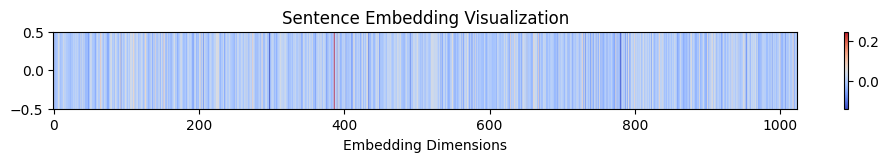

In [8]:
# Converting embedding to a NumPy array
embedding_np = np.array(embeddings[0])

# Creating a heatmap
plt.figure(figsize=(12, 1))
plt.imshow(embedding_np.reshape(1, -1), cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Sentence Embedding Visualization")
plt.xlabel("Embedding Dimensions")
plt.ylim(-0.5, 0.5)
plt.show()

#### **Sentence Similarity**

In [9]:
# Sentence for query (0 = first sentence)
query_idx = 0
query_embedding = embeddings[query_idx]

# Computing similarities
similarities = np.dot(embeddings, query_embedding)

# Sorting by similarity
sorted_idx = np.argsort(similarities)[::-1]  # Descending order

# Outputting top 2 most similar sentences
print(f"Most Similar Sentences to: {sentences[query_idx]}")
for idx in sorted_idx[1:3]:  # Exclude self-comparison
    print(f"- {sentences[idx]} (Score: {similarities[idx]:.3f})")

Most Similar Sentences to: The golden rays of the setting sun painted the sky in shades of orange and pink.
- The city skyline shimmered in the golden light of the setting sun. (Score: 0.747)
- A sudden downpour drenched the city streets, leaving behind the fresh scent of rain. (Score: 0.556)


#### **Cosine Similarity Matrix**

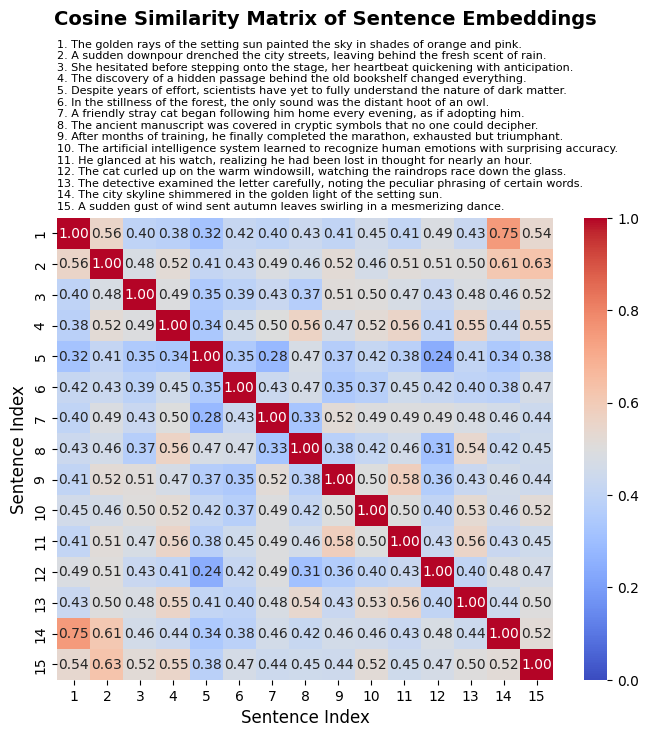

In [10]:
# Computing the cosine similarity matrix
similarity_matrix = cos_sim(embeddings, embeddings).numpy()

# Creating numerical labels base on number of sentences for visualization
num_labels = [str(i+1) for i in range(len(sentences))]

# Creating the figure and heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, vmin=0, vmax=1, fmt=".2f", cmap="coolwarm", xticklabels=num_labels, yticklabels=num_labels, ax=ax)

# Formatting for readability
ax.set_xticklabels(num_labels, rotation=0, fontsize=10)
ax.set_yticklabels(num_labels, fontsize=10)
ax.set_title("Cosine Similarity Matrix of Sentence Embeddings", fontsize=14, fontweight="bold", x=0.54, y=1.4)
ax.set_xlabel("Sentence Index", fontsize=12)
ax.set_ylabel("Sentence Index", fontsize=12)

# Adding a text box with the sentences
sentence_text = "\n".join([f"{i+1}. {sent}" for i, sent in enumerate(sentences)])
props = dict(boxstyle='round', facecolor='white', edgecolor='white', alpha=0.7)
fig.text(0, 1.2, sentence_text, transform=ax.transAxes, fontsize=8, verticalalignment='center', bbox=props)

# Showing plot
plt.show()

#### **K-Means Clustering t-SNE 2D Plot of Embeddings**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


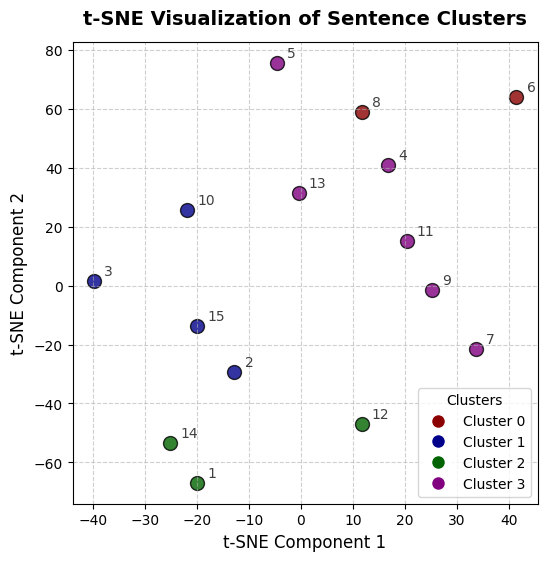

In [11]:
# Number of K-means clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Reducing dimensions for visualization
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

# Defining colors for clusters
colors = ['darkred', 'darkblue', 'darkgreen', 'purple']
cluster_colors = [colors[label] for label in labels]

# Plotting clusters
plt.figure(figsize=(6, 6))
for i, sentence in enumerate(sentences):
    plt.scatter(embeddings_2d_tsne[i, 0], embeddings_2d_tsne[i, 1], color=cluster_colors[i], edgecolors='k', s=100, alpha=0.8)
    plt.text(embeddings_2d_tsne[i, 0] + 2, embeddings_2d_tsne[i, 1] + 2, str(i+1), fontsize=10, alpha=0.75)

plt.title("t-SNE Visualization of Sentence Clusters", fontsize=14, fontweight="bold", y=1.02)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Adding legend
legend_labels = [f"Cluster {i}" for i in range(num_clusters)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(num_clusters)]
plt.legend(handles, legend_labels, title="Clusters", loc="lower right")

# Showing plot
plt.show()

# 2 - Multi-Task Learning
---

In [12]:
# Loading pre-trained BGE-M3 model
model_name = "BAAI/bge-m3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

## Task Specific Heads
---
### Changes Made to Transformer Backbone Architecture
- Two task specific heads were added.
- The backbone transformer's output is now routed to two separate heads.
- Predictions are returned independently for each task.

### Sentence Classification Model Architecture

- **First Linear Layer**
    - A simple fully connected layer added on top of the transformer’s hidden layer to map embeddings. 
    - Chosen for simplicity and efficiency, providing strong classification performance without excessive computational cost or risk of overfitting.
    - Input size was set to 128 to reduce the dimensionality of MiniLM’s 384-dimensional embeddings, and to balance the trade-off between accuracy and resource efficiency.
- **ReLU Activation Function**
    - Introduces non-linearity, helping the model learn more complex language patterns.
    - Chosen for computational efficiency and to promote sparse activation (setting -ve values to 0) which helps prevent overfitting.
    - ReLU activation avoids the vanishing gradient problem.
- **Second Linear Layer** 
    - Another simple linear layer to map the extracted features to the correct sentence class (softmax will be applied later).

This classification head only uses the CLS token representation, meaning it classifies the entire sentence.

### Named Entity Recognition (NER) Architecture

- **Linear Layer**
    - Simple, computationally efficient architecture chosen for head fine-tuning because transformer backbone has already extracted complex features.
    - Dimensions chosen to match the last hidden layer output as NER is a token level task and predictions will be generated per token.

In [13]:
# Multi-Task Model Inheriting from PyTorch's Neural Network Module

class MultiTaskModel(nn.Module):

    def __init__(self, base_model, num_classes, num_ner_labels):

        """
        Arguments:
        _____________________

        base_model        The pre-trained transformer model
        num_classes       Number of category classes for sentence classification
        num_ner_labels    Number of entity classes for Named Entity Recognition (NER)

        """

        # Calling PyTorch parent constructor to initialize neural network model
        super(MultiTaskModel, self).__init__()

        # Transformer Backbone -----------------------------------------------------------
        self.base_model = base_model

        # Head 1 - Sentence Classification -----------------------------------------------
        self.classifier = nn.Sequential(
            nn.Linear(base_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # Head 2 - Named Entity Recognition ----------------------------------------------
        self.ner_head = nn.Linear(base_model.config.hidden_size, num_ner_labels)


    def forward(self, input_ids, attention_mask):

        """
        Arguments:
        _____________________

        input_ids          The tokenized input text
        attention_mask     The mask that specifies which tokens are words or padding

        """

        # Passing tokens through transformer backcone and extracting the hidden states
        outputs = self.base_model(input_ids = input_ids, attention_mask = attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [Batch, Seq_len, Hidden_dim]

        # Head 1 - Sentence Classification -----------------------------------------------

        # Extracting the CLS token representation 
        cls_embedding = last_hidden_state[:, 0, :]
        # Passing the CLS tokens to the classification head to get the logits
        classification_logits = self.classifier(cls_embedding)

        # Head 2 - Named Entity Recognition ----------------------------------------------

        # Passing full sequence output to ner_head to classify each token in the sentence
        ner_logits = self.ner_head(last_hidden_state)  # [Batch, Seq_len, NER_labels]

        return classification_logits, ner_logits

# 3 - Training Considerations
---
## Freezing 

##### **Freezing the Entire Network**
Advantages: 
- No weights are updated, so computationally efficient and fast to produce predictions.
- For datasets which are similiar to the original training set, the model is likely to retain accuracy.

Implications:
- The model is frozen and so cannot adapt if data is rapidly evolving or new classes are appearing.

##### **Freezing the Transformer Backbone**

Advantages: 
- By training only the task specific heads, the model can adapt well to tasks while remaining efficient.
- If the transformer backbone has high quality embeddings, results can retain a high accuracy without too much computational power used for training.

Implications:
- A good option for most use cases, as it balances accuracy and efficiency. However, if the target dataset has significant domain differences from the pre-trained data (e.g., highly technical financial/legal text or informal social media text), freezing the transformer backbone may limit adaptation.

##### **Freezing a Task-Specific Head**

Advantages: 
-  Useful when one task is well-learned but the other needs adaptation, freezing prevents negative task interference.
- Efficient training for incremental learning, as freezing one head reduces parameter updates.

Implications:
- Freezing one head may lead to imbalanced learning, as only one task contributes to updating the transformer backbone. Over time, the frozen head may fall behind in performance, especially if the underlying text representations evolve.

##### **Overall Rationale**
- For this application, I would chose to freeze the model backbone during initial training. After evaluating the initial results, I would then aim to do an A/B test for freezing each head and investigate how this changes the model accuracy and prediction outcomes.


## Transfer Learning

##### **Choosing a Pre-Trained Model**

- Selecting a pre-trained model would depend heavily on the intended application, scope and volume of data for the task at hand.
- In general, I would look for a pre-trained model which:
    - Was trained using data similar to the target task
    - Is efficient and scalable
    - Supports multi-task learning effectively

##### **Freezing Layers**
- Early transformer layers capture low-level syntactic patterns (e.g., word structure, basic grammar), which remain consistent across tasks and don’t require re-training.
- The last few layers would be unfrozen to allow domain adaptation, enabling the model to learn receipt-specific nuances in classification and NER. 
- I would leave the task-specific heads trainable, so that they are able to adjust to new categories and entity types. 
- These choices balance computational efficiency with task adaptation, preventing catastrophic forgetting while leveraging the pre-trained model’s knowledge.

##### **Overall Rationale**
- In this specific task I chose the pre-trained BGE-M3 model as it was efficient, pre-trained on multiple NLP tasks, has good sentence embeddings and rich token-level representations (great for NER).
- In my training loop, I kept the task-specific heads unfrozen while freezing the transformer backbone. This significantly reduces computational cost, as only the classification and NER layers are updated, making fine-tuning much faster while still leveraging strong pre-trained sentence embeddings.

# 4 - Training Loop Implementation
---

### **Assumptions About Hypothetical Dataset**
- I chose to design the task for sentences that would be extracted from typical receipts. For example:
    - "Thank you, your total is: $32.66"
    - "500g Organic Canned Tomatoes"
- Assuming that dataset is in PyTorch compatible format, is tokenized and in a dictionary containing:
	1. Raw Sentences
    2. Input IDs (input_ids)
	3. Attention Mask (attention_mask)
	4. Sentence Classification Label (classification_label)
	5. Token-Level NER Labels (ner_labels)
- For training the Sentence Classifier I have assumed 4 categories, for example:
    - Product Name
    - Store Name
    - Price
    - Other
- For the NER labels, I have assumed 5 labels, for example:
    - O - An outside entity
    - B-PRODUCT - The beginning of a product name
    - I-PRODUCT - Inside of a product name
    - B-PRICE - The beginning of a price entity
    - I-PRICE - Inside of a price entity

### **Notes on Implementation of Forward Pass**
- GPU Acceleration for Faster Training
    - The model and tensors are moved to CUDA when available to enable parallel computation on GPUs.
	- This ensures matrix multiplications are handled efficiently.
    
- Mini-Batch Training
    - Instead of processing all samples at once, training is done in batches to optimize memory usage.
    - This stabilizes gradient updates, making training smoother and reducing variance.
	- Training speed is also improved bevause batches are processed in parallel on GPUs.

- Granularity of Outputs for Different Heads
    - Sentence classification uses only the CLS token embedding since it represents the whole sentence which trains to capture the global sentence meaning.
    - NER head requires predictions for each token in the input sequence because NER is a token-level task.

- Joint Optimization with Separate Losses
    - I chose to compute the loss for both heads independently and then combine them into a final loss to allow for joint optimization of both heads.
    - This allows for balanced learning and keeps training stable.

- Loss Backpropogates Through Both Tasks
    - Losses are summed, so the gradients flow through the shared transformer backbone.
    - This allows for transformer fine tuning and shared knowledge to improve both tasks.

- Gradient Clipping Implementation
    - Chosen to prevent exploding gradients and extreme weight updates from destabilizing multi-task learning.

### **Notes on Evaluation Metrics**

- Accuracy & F1 Computed for Both Tasks
    - Accuracy computed separately for each head to check for task imbalance.


In [14]:
def train_multitask_model(model, train_dataloader, val_dataloader, optimizer, classification_loss_fn, ner_loss_fn, epochs = 5):
    """
    Arguments:
    _____________________

    model                       The multi-task model
	train_dataloader            DataLoader for training data
	val_dataloader              DataLoader for validation data
	optimizer                   Optimizer (e.g. AdamW) which updates the model weights
	classification_loss_fn      Loss function for sentence classification
	ner_loss_fn                 Loss function for NER
	epochs                      Number of training iterations

    """
    # Use GPU if available to speed up training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Iterating for the chosen no. of epochs
    for epoch in range(epochs):

        # --------------------------------------------------------------------------------
        # Training Step
        # --------------------------------------------------------------------------------

        # Initializing model to train
        model.train()

        # Initializing the loss trackers
        total_class_loss = 0.0
        total_ner_loss = 0.0

        # Initializing empty lists for true and predicted labels
        classification_preds, classification_labels = [], []
        ner_preds, ner_labels = [], []

        # Iterating through training data in batches to allow for parallelization
        for batch in train_dataloader:

            # Moving current batch data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            classification_labels_batch = batch["classification_label"].to(device)
            ner_labels_batch = batch["ner_labels"].to(device)

            # Resetting gradient of optimizer from prevvious batch
            optimizer.zero_grad()

            # Performing forward pass through multi-task model to get logits
            classification_logits, ner_logits = model(input_ids, attention_mask)

            # Computing loss for each head (NER logit reshaped to match label dimension)
            class_loss = classification_loss_fn(classification_logits, classification_labels_batch)
            ner_loss = ner_loss_fn(ner_logits.view(-1, ner_logits.shape[-1]), ner_labels_batch.view(-1))

            # Adds both losses to optimize together and backpropagates gradients to update model weights
            total_loss = class_loss + ner_loss
            total_loss.backward()

            # Limiting size of gradient to prevent instability (gradient clipping)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
            
            # Updating model parameters based on computed gradients
            optimizer.step()

            # Tracking total classification loss and NER loss for reporting later
            total_class_loss += class_loss.item()
            total_ner_loss += ner_loss.item()

            # Converting logits into class predictions and moving data to CPU for accuracy calculations
            classification_preds.extend(torch.argmax(classification_logits, dim = 1).cpu().numpy())
            classification_labels.extend(classification_labels_batch.cpu().numpy())
            ner_preds.extend(torch.argmax(ner_logits, dim = -1).cpu().numpy().flatten())
            ner_labels.extend(ner_labels_batch.cpu().numpy().flatten())

        # Compute training accuracy metrics
        train_class_acc = accuracy_score(classification_labels, classification_preds)
        train_f1 = f1_score(classification_labels, classification_preds, average = "weighted")

        # Printing training results
        print(f"Epoch {epoch+1}/{epochs} - Classification Loss: {total_class_loss:.4f}, NER Loss: {total_ner_loss:.4f}, Train Accuracy: {train_class_acc:.4f}, Train F1: {train_f1:.4f}")

        # --------------------------------------------------------------------------------
        # Validation Step
        # --------------------------------------------------------------------------------

        # Initializing model to validate disabling dropout
        model.eval()

        # Initializing the loss trackers
        val_class_loss = 0.0
        val_ner_loss = 0.0

        # Initializing empty lists for true and predicted labels
        val_classification_preds, val_classification_labels = [], []
        val_ner_preds, val_ner_labels = [], []

        # Disabling gradient tracking to save memory and speed up evaluation
        with torch.no_grad():

            # Iterating through validation data in batches to allow for parallelization
            for batch in val_dataloader:

                # Moving current batch data to device
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                classification_labels_batch = batch["classification_label"].to(device)
                ner_labels_batch = batch["ner_labels"].to(device)

                # Performing validation forward pass through multi-task model to get logits
                classification_logits, ner_logits = model(input_ids, attention_mask)

                # Computing validation loss for each head
                class_loss = classification_loss_fn(classification_logits, classification_labels_batch)
                ner_loss = ner_loss_fn(ner_logits.view(-1, ner_logits.shape[-1]), ner_labels_batch.view(-1))

                # Tracking total classification loss and NER loss for reporting
                val_class_loss += class_loss.item()
                val_ner_loss += ner_loss.item()

                # Converting logits into class predictions and moving data to CPU for accuracy calculations
                val_classification_preds.extend(torch.argmax(classification_logits, dim=1).cpu().numpy())
                val_classification_labels.extend(classification_labels_batch.cpu().numpy())
                val_ner_preds.extend(torch.argmax(ner_logits, dim=-1).cpu().numpy().flatten())
                val_ner_labels.extend(ner_labels_batch.cpu().numpy().flatten())

        # Computing validation metrics
        val_class_acc = accuracy_score(val_classification_labels, val_classification_preds)
        val_f1 = f1_score(val_classification_labels, val_classification_preds, average="weighted")

        # Printing validation results
        print(f"Validation - Classification Loss: {val_class_loss:.4f}, NER Loss: {val_ner_loss:.4f}, Val Accuracy: {val_class_acc:.4f}, Val F1: {val_f1:.4f}")

In [ ]:
# Splitting Dataset for Training/Validation
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# NOTE: Repeated cell from above for readabillity
model_name = "BAAI/bge-m3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

In [ ]:
# Training the Multi-Task Model
multi_task_model = MultiTaskModel(base_model, num_classes = 4, num_ner_labels = 5)

train_multitask_model(
    model = multi_task_model, 
    train_dataloader = train_dataloader, 
    val_dataloader = val_dataloader, 
    optimizer = optim.AdamW(multi_task_model.parameters(), lr = 2e-5), 
    classification_loss_fn = nn.CrossEntropyLoss(), 
    ner_loss_fn = nn.CrossEntropyLoss(), 
    epochs = 5
)